# Spectral Reconstruction: CAVE

In [1]:
import json
import pickle
from pathlib import Path

import optuna
import numpy as np
import pandas as pd
import spectral as spy
from tqdm import tqdm

from sklearn.metrics import make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('bgr', ['#494ca0', '#72bf75', '#9a4545'])

from regression import RELS

C:\Projects\suspectral\suspectral-notebook\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
optimize_hyperparameters = False

## Metrics

In [3]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2, axis=1))

def mrae(y_true, y_pred, epsilon: float = 1e-3):
    return np.mean(np.abs(y_true - y_pred) / (y_true + epsilon), axis=1)

In [4]:
rmse_scorer = make_scorer(lambda y_true, y_pred: np.mean(rmse(y_true, y_pred)), greater_is_better=False)
mrae_scorer = make_scorer(lambda y_true, y_pred: np.mean(mrae(y_true, y_pred)), greater_is_better=False)

## Dataset

In [5]:
height, width, depth = 512, 508, 31
bands = np.arange(400, 700 + 1, 10)

In [6]:
with open('resources/CAVE.json', 'r') as file:
    json_data = json.load(file)
    images_test = [Path(f'datasets/CAVE/{it}.hdr') for it in json_data['test']]
    images_train = [Path(f'datasets/CAVE/{it}.hdr') for it in json_data['train']]

In [7]:
def load(path: Path):
    envi = spy.io.envi.open(path)
    y = envi.load()
    y = y.reshape(-1, y.shape[-1])

    X = np.load(path.with_suffix('.npy'))
    X = X.reshape(-1, X.shape[-1])
    return X, y

In [8]:
def load_dataset(images: list[Path]):
    Xs, ys = [], []

    for path in images:
        X, y = load(path)
        Xs.append(X)
        ys.append(y)

    return np.vstack(Xs), np.vstack(ys)

In [9]:
X_train, y_train = load_dataset(images_train)

In [10]:
kf = KFold(n_splits=5, shuffle=False)

## Model: LR

In [11]:
model_lr = LinearRegression(fit_intercept=False)
model_lr.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [12]:
with open('models/CAVE_LR.pkl', 'wb') as file:
    pickle.dump(model_lr, file, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
print(f'RMSE: {-np.mean(cross_val_score(model_lr, X_train, y_train, cv=kf, scoring=rmse_scorer))}')
print(f'MRAE: {-np.mean(cross_val_score(model_lr, X_train, y_train, cv=kf, scoring=mrae_scorer))}')

RMSE: 0.019871252118262916
MRAE: 0.26256584100306507


In [14]:
lr_mean_rmse_costs = []
lr_mean_mrae_costs = []

for path in tqdm(images_test):
    X_test, y_test = load(path)
    y_pred = model_lr.predict(X_test)

    lr_mean_rmse_costs.append(np.mean(rmse(y_test, y_pred)))
    lr_mean_mrae_costs.append(np.mean(mrae(y_test, y_pred)))

    del X_test, y_test, y_pred

pd.DataFrame({
    'Mean RMSE': lr_mean_rmse_costs,
    'Mean MRAE': lr_mean_mrae_costs,
}, index=images_test).describe()

100%|██████████| 2/2 [00:00<00:00,  6.09it/s]


,Mean RMSE,Mean MRAE
count,2.000000,2.000000
mean,0.015467,0.148788
std,0.001015,0.012005
min,0.014749,0.140299
25%,0.015108,0.144543
50%,0.015467,0.148788
75%,0.015826,0.153032
max,0.016185,0.157276


In [15]:
X_test, y_test = load(images_test[1])
y_pred = model_lr.predict(X_test)

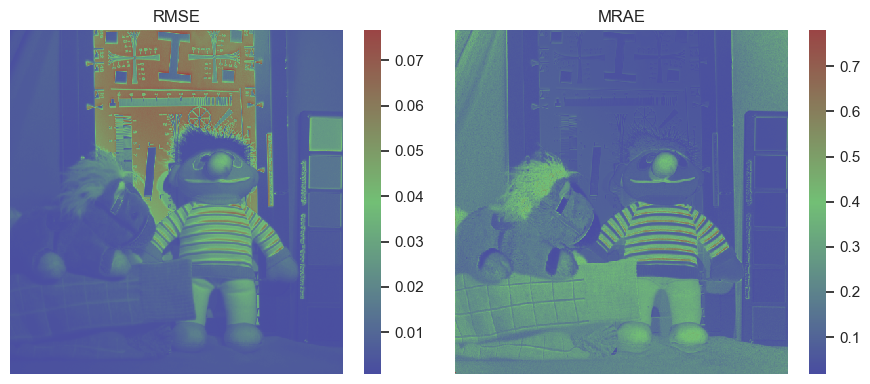

In [16]:
_, axes = plt.subplots(ncols=2, figsize=(9, 4))

rmse_lr = rmse(y_test, y_pred)
rmse_lr = rmse_lr.reshape(height, width)

sns.heatmap(rmse_lr, cmap=cmap, ax=axes[0])
axes[0].set_title('RMSE')
axes[0].set_xticks([])
axes[0].set_yticks([])

mrae_lr = mrae(y_test, y_pred)
mrae_lr = mrae_lr.reshape(height, width)

sns.heatmap(mrae_lr, cmap=cmap, ax=axes[1])
axes[1].set_title('MRAE')
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.tight_layout()
plt.show()

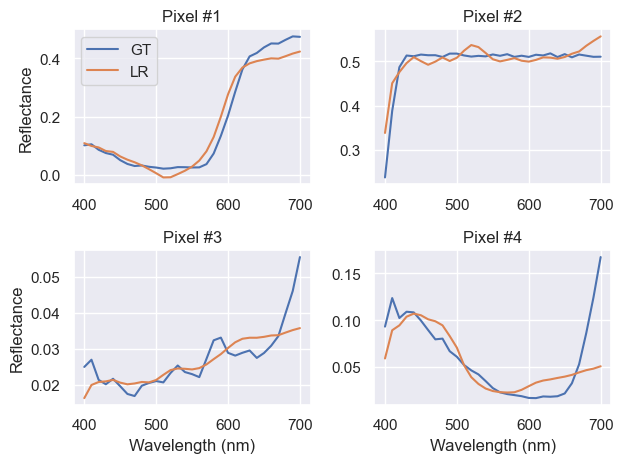

In [17]:
_, axes = plt.subplots(nrows=2, ncols=2)

axes[0, 0].set_title('Pixel #1')
axes[0, 0].plot(bands, y_test[197 * width + 324], label='GT')
axes[0, 0].plot(bands, y_pred[197 * width + 324], label='LR')
axes[0, 0].set_ylabel('Reflectance')
axes[0, 0].legend()

axes[0, 1].set_title('Pixel #2')
axes[0, 1].plot(bands, y_test[153 * width + 485], label='GT')
axes[0, 1].plot(bands, y_pred[153 * width + 485], label='LR')

axes[1, 0].set_title('Pixel #3')
axes[1, 0].plot(bands, y_test[288 * width + 164], label='GT')
axes[1, 0].plot(bands, y_pred[288 * width + 164], label='LR')
axes[1, 0].set_xlabel('Wavelength (nm)')
axes[1, 0].set_ylabel('Reflectance')

axes[1, 1].set_title('Pixel #4')
axes[1, 1].plot(bands, y_test[400 * width + 355], label='GT')
axes[1, 1].plot(bands, y_pred[400 * width + 355], label='LR')
axes[1, 1].set_xlabel('Wavelength (nm)')

plt.tight_layout()
plt.show()

In [18]:
del X_test, y_test, y_pred

## Model: PR

In [19]:
def pr_objective(trial):
    alpha = trial.suggest_float('alpha', 1e-6, 1e2, log=True)
    order = trial.suggest_int('order', 2, 6)

    X_train_poly = PolynomialFeatures(degree=order, include_bias=False) \
        .fit_transform(X_train)

    model = Ridge(alpha=alpha, fit_intercept=False)
    return -np.mean(cross_val_score(
        model, X_train_poly, y_train, cv=kf, scoring=mrae_scorer))

In [20]:
if optimize_hyperparameters:
    study = optuna.create_study(direction='minimize')
    study.optimize(pr_objective, n_trials=100)
    print(study.best_params)

In [21]:
model_pr = make_pipeline(
    PolynomialFeatures(degree=6, include_bias=False),
    Ridge(alpha=0.0001647050258728194),
)

In [22]:
model_pr.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=6, include_bias=False)),
                ('ridge', Ridge(alpha=0.0001647050258728194))])

In [23]:
with open('models/CAVE_PR.pkl', 'wb') as file:
    pickle.dump(model_pr, file, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
print(f'RMSE: {-np.mean(cross_val_score(model_pr, X_train, y_train, cv=kf, scoring=rmse_scorer))}')
print(f'MRAE: {-np.mean(cross_val_score(model_pr, X_train, y_train, cv=kf, scoring=mrae_scorer))}')

RMSE: 0.014311126079559023
MRAE: 0.14990065377641076


In [25]:
pr_mean_rmse_costs = []
pr_mean_mrae_costs = []

for path in tqdm(images_test):
    X_test, y_test = load(path)
    y_pred = model_pr.predict(X_test)

    pr_mean_rmse_costs.append(np.mean(rmse(y_test, y_pred)))
    pr_mean_mrae_costs.append(np.mean(mrae(y_test, y_pred)))

    del X_test, y_test, y_pred

pd.DataFrame({
    'Mean RMSE': pr_mean_rmse_costs,
    'Mean MRAE': pr_mean_mrae_costs,
}, index=images_test).describe()

100%|██████████| 2/2 [00:00<00:00,  2.52it/s]


,Mean RMSE,Mean MRAE
count,2.000000,2.000000
mean,0.014775,0.125086
std,0.002976,0.001791
min,0.012670,0.123820
25%,0.013722,0.124453
50%,0.014775,0.125086
75%,0.015827,0.125720
max,0.016879,0.126353


In [26]:
X_test, y_test = load(images_test[1])
y_pred = model_pr.predict(X_test)

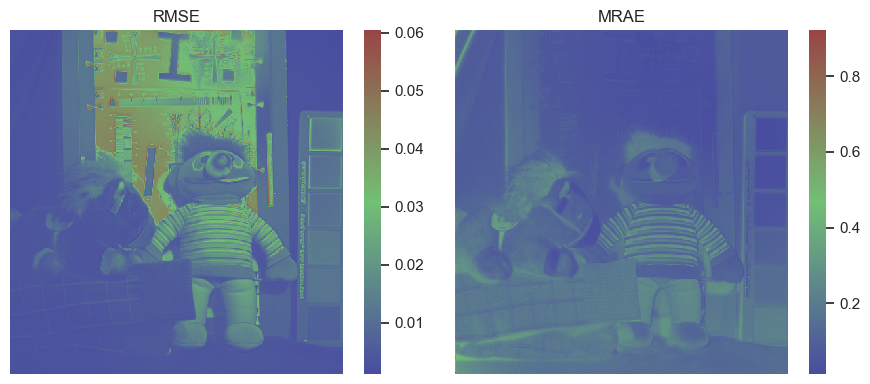

In [27]:
_, axes = plt.subplots(ncols=2, figsize=(9, 4))

rmse_pr = rmse(y_test, y_pred)
rmse_pr = rmse_pr.reshape(height, width)

sns.heatmap(rmse_pr, cmap=cmap, ax=axes[0])
axes[0].set_title('RMSE')
axes[0].set_xticks([])
axes[0].set_yticks([])

mrae_pr = mrae(y_test, y_pred)
mrae_pr = mrae_pr.reshape(height, width)

sns.heatmap(mrae_pr, cmap=cmap, ax=axes[1])
axes[1].set_title('MRAE')
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.tight_layout()
plt.show()

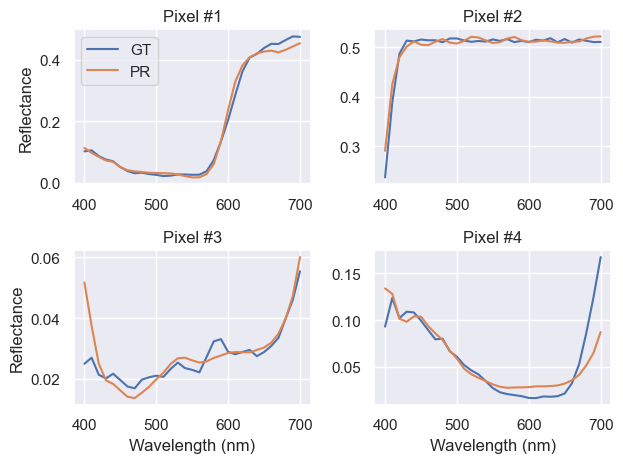

In [28]:
_, axes = plt.subplots(nrows=2, ncols=2)

axes[0, 0].set_title('Pixel #1')
axes[0, 0].plot(bands, y_test[197 * width + 324], label='GT')
axes[0, 0].plot(bands, y_pred[197 * width + 324], label='PR')
axes[0, 0].set_ylabel('Reflectance')
axes[0, 0].legend()

axes[0, 1].set_title('Pixel #2')
axes[0, 1].plot(bands, y_test[153 * width + 485], label='GT')
axes[0, 1].plot(bands, y_pred[153 * width + 485], label='PR')

axes[1, 0].set_title('Pixel #3')
axes[1, 0].plot(bands, y_test[288 * width + 164], label='GT')
axes[1, 0].plot(bands, y_pred[288 * width + 164], label='PR')
axes[1, 0].set_xlabel('Wavelength (nm)')
axes[1, 0].set_ylabel('Reflectance')

axes[1, 1].set_title('Pixel #4')
axes[1, 1].plot(bands, y_test[400 * width + 355], label='GT')
axes[1, 1].plot(bands, y_pred[400 * width + 355], label='PR')
axes[1, 1].set_xlabel('Wavelength (nm)')

plt.tight_layout()
plt.show()

## Model: RELS

In [29]:
X_train_poly = PolynomialFeatures(degree=6, include_bias=False) \
    .fit_transform(X_train)

In [30]:
rels_models = []

for train_index, val_index in tqdm(kf.split(y_train)):
    model = RELS(n_features=83, n_bands=len(bands), epsilon=1)
    model.add(X_train_poly[train_index], y_train[train_index])
    rels_models.append(model)

5it [08:10, 98.10s/it]


In [31]:
def rels_objective(trial):
    alphas = [
        trial.suggest_float(f'alpha[{i}]', 1e-6, 1e2, log=True)
        for i in range(len(bands))
    ]

    scores = []
    for k, (train_index, val_index) in enumerate(kf.split(y_train)):
        model = rels_models[k].fit(alphas=alphas)
        y_pred = model.predict(X_train_poly[val_index])
        y_true = y_train[val_index]
        scores.append(np.mean(mrae(y_pred, y_true)))

    return np.mean(scores)

In [32]:
if optimize_hyperparameters:
    study = optuna.create_study(direction='minimize')
    study.optimize(rels_objective, n_trials=1000)
    print(study.best_params)

In [33]:
model_rels = RELS(n_features=83, n_bands=len(bands), epsilon=1)
model_rels.add(X_train_poly, y_train)
model_rels.fit(alphas=[
    9.167940851994347e-05,
    1.62308017250488e-05,
    3.143669764668418e-05,
    8.4837786407067e-06,
    0.0002006697277782615,
    0.9523717975669214,
    7.224517297584274e-05,
    6.592710540437391e-06,
    0.002108766622579387,
    6.624336445561342e-05,
    7.417790397163852e-05,
    0.0026594965964144516,
    0.002181538984838119,
    0.0003499529036507485,
    0.00023282105643388691,
    0.04132309257046656,
    1.6526542578010536e-05,
    0.0005819712548505592,
    0.07828054570588462,
    0.3857591606862261,
    2.913099685744614e-06,
    0.00032569002888711645,
    0.02313055393152699,
    0.6620896349170335,
    0.0004152663407148254,
    0.01142977612936923,
    6.390928798191094e-05,
    0.005669475547460803,
    2.576524095522732e-05,
    0.0020733081840595895,
    2.8474972490522377
]);

In [34]:
with open('models/CAVE_RELS.pkl', 'wb') as file:
    pickle.dump(model_rels, file, protocol=pickle.HIGHEST_PROTOCOL)

In [35]:
rels_cv_rmse_costs = []
rels_cv_mrae_costs = []

for k, (train_index, val_index) in enumerate(kf.split(y_train)):
    y_pred = model_rels.predict(X_train_poly[val_index])
    y_true = y_train[val_index]
    rels_cv_rmse_costs.append(np.mean(rmse(y_pred, y_true)))
    rels_cv_mrae_costs.append(np.mean(mrae(y_pred, y_true)))

In [36]:
print(f'RMSE: {np.mean(rels_cv_rmse_costs)}')
print(f'MRAE: {np.mean(rels_cv_mrae_costs)}')

RMSE: 0.012113782713284749
MRAE: 0.1147679498537892


In [37]:
rels_mean_rmse_costs = []
rels_mean_mrae_costs = []

for path in tqdm(images_test):
    X_test, y_test = load(path)
    y_pred = model_rels.predict(PolynomialFeatures(degree=6, include_bias=False).fit_transform(X_test))

    rels_mean_rmse_costs.append(np.mean(rmse(y_test, y_pred)))
    rels_mean_mrae_costs.append(np.mean(mrae(y_test, y_pred)))

    del X_test, y_test, y_pred

pd.DataFrame({
    'Mean RMSE': rels_mean_rmse_costs,
    'Mean MRAE': rels_mean_mrae_costs,
}, index=images_test).describe()

100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


,Mean RMSE,Mean MRAE
count,2.000000,2.000000
mean,0.014584,0.116227
std,0.002966,0.011902
min,0.012486,0.107811
25%,0.013535,0.112019
50%,0.014584,0.116227
75%,0.015633,0.120435
max,0.016682,0.124643


In [38]:
X_test, y_test = load(images_test[1])
X_test_poly = PolynomialFeatures(degree=6, include_bias=False).fit_transform(X_test)
y_pred = model_rels.predict(X_test_poly)

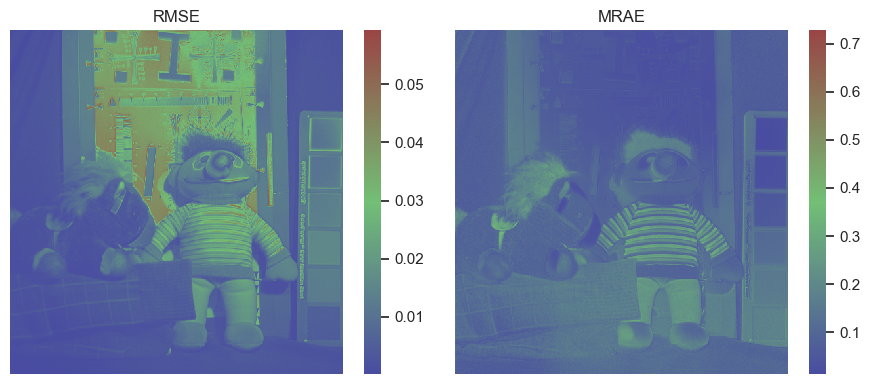

In [39]:
_, axes = plt.subplots(ncols=2, figsize=(9, 4))

rmse_pr = rmse(y_test, y_pred)
rmse_pr = rmse_pr.reshape(height, width)

sns.heatmap(rmse_pr, cmap=cmap, ax=axes[0])
axes[0].set_title('RMSE')
axes[0].set_xticks([])
axes[0].set_yticks([])

mrae_pr = mrae(y_test, y_pred)
mrae_pr = mrae_pr.reshape(height, width)

sns.heatmap(mrae_pr, cmap=cmap, ax=axes[1])
axes[1].set_title('MRAE')
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.tight_layout()
plt.show()

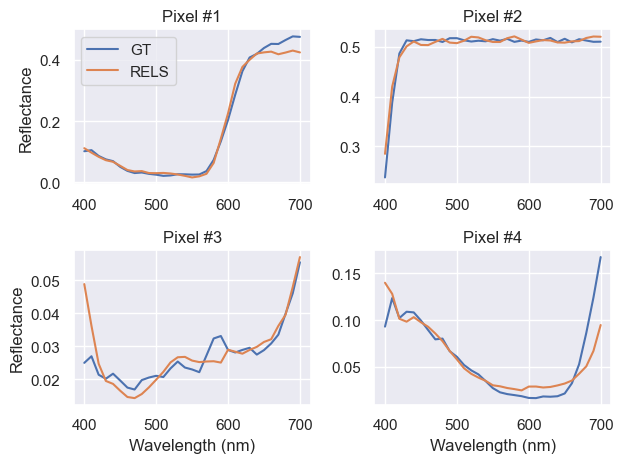

In [40]:
_, axes = plt.subplots(nrows=2, ncols=2)

axes[0, 0].set_title('Pixel #1')
axes[0, 0].plot(bands, y_test[197 * width + 324], label='GT')
axes[0, 0].plot(bands, y_pred[197 * width + 324], label='RELS')
axes[0, 0].set_ylabel('Reflectance')
axes[0, 0].legend()

axes[0, 1].set_title('Pixel #2')
axes[0, 1].plot(bands, y_test[153 * width + 485], label='GT')
axes[0, 1].plot(bands, y_pred[153 * width + 485], label='RELS')

axes[1, 0].set_title('Pixel #3')
axes[1, 0].plot(bands, y_test[288 * width + 164], label='GT')
axes[1, 0].plot(bands, y_pred[288 * width + 164], label='RELS')
axes[1, 0].set_xlabel('Wavelength (nm)')
axes[1, 0].set_ylabel('Reflectance')

axes[1, 1].set_title('Pixel #4')
axes[1, 1].plot(bands, y_test[400 * width + 355], label='GT')
axes[1, 1].plot(bands, y_pred[400 * width + 355], label='RELS')
axes[1, 1].set_xlabel('Wavelength (nm)')

plt.tight_layout()
plt.show()